# Reviews mining -  topic modeling
*M.S. student Darius Alexandru Cocirta*

![alternatvie text](https://cdn.searchenginejournal.com/wp-content/uploads/2021/04/google-product-reviews-update-606f3672ab023.jpg)

## Introduction

A restaurant contacts you to help them improve their business. They provide you with a customer reviews
dataset and ask you to analyse **what customers think and which services can be made better**.

## Data

The dataset consists of 1000 textual review (of a restaurant) and its positive or negative label.

## Assignment

The main task of the project is to apply different text mining methods to investigate what customers like and
dislike about the restaurant. The report should contain methodological details and results & suggestions on what is good or can be improved. The implementation can be done in both R and Python and all of the codes should be saved so you can
provide them if needed.

## Description of analysis

The purpose of this project is to use **topic modeling** to accurately reveal the true opinions of clients. 

For this, I first started with a **preliminary analysis** for a better understanding of the data.

Further, I used the **VADER model to reveal the sentiment score of reviews** for a better data normalization designed to serve the purpose of a better topic modeling analysis. By having labeled data, helped me in counteracting the model's deficiencies, caused by the ambiguity of human language. The ambiguity of human language is the biggest challenge of text mining.

In the last step of my analysis, using topic modeling, I have revealed the main topics of discussion of the customers regarding the services of the restaurant and I proposed things to maintain or to improve.

## Data quality assessment

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import re
import nltk
#nltk.download('stopwords')
#nltk.download('vader_lexicon')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import requests

#Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models import TfidfModel

#spacy
import spacy

#pyLDSvis
import pyLDAvis.gensim_models

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [2]:
mydata = pd.read_csv(r'C:\Users\Asus\Desktop\dis\p_reviews\Restaurant_Reviews.tsv', sep='\t')

In [3]:
mydata.shape

(1000, 2)

In [4]:
mydata.head()

,Review,Liked
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


In [5]:
mydata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  1000 non-null   object
 1   Liked   1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


### Creating  two datasets with positive and negative reviews separately

In [6]:
positive = mydata[mydata['Liked'] == 1]
mydata[mydata['Liked'] == 1].head(3)

,Review,Liked
0,Wow... Loved this place.,1
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


In [7]:
positive.shape

(500, 2)

In [8]:
negative = mydata[mydata['Liked'] == 0]
mydata[mydata['Liked'] == 0].head(3)

,Review,Liked
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
5,Now I am getting angry and I want my damn pho.,0


In [9]:
negative.shape

(500, 2)

## Data pre processing

In this step of my analysis I have created a function designed to be applied on every review in order to get a clean corpus of words, later used in the modeling part. I converted from upper to lower case, I replaced everything that is not a letter (digits too) with an " " empty space, I removed the stopwords using stopwords list from nltk.corpus but also, for getting better results on the modeling part, I also used another english stopwords list from the link below, a list consisting of ~1000 words, using *requests* library. I used lemmatization because I wanted to keep the original words for visualization reasons.

In [10]:
def text_process(review):
    review = re.sub('[^^a-zA-Z]', ' ', review) # repleace everything that is not a-zA-Z with ' ' from data[i] (numbers)
    review = review.lower() # lower
    review = [word for word in review.split() if word not in stopwords.words('english')] # remove stop words from nltk.corpus [x words]
    # list of more than 1000 english stopwords; using requests to get the list
    stopwords_list = requests.get("https://gist.githubusercontent.com/rg089/35e00abf8941d72d419224cfd5b5925d/raw/12d899b70156fd0041fa9778d657330b024b959c/stopwords.txt").content
    stopwords2 = set(stopwords_list.decode().splitlines())
    review = [word for word in review if word.lower() not in stopwords2] # remove stopwards again but from second stopords list
    lemmatizer = WordNetLemmatizer() # lemmatization
    review = [lemmatizer.lemmatize(word) for word in review]
    return(review)

## Positive reviews - Negative reviews. Data transformation & preliminary analysis

### Applying pre processing function on reviews

In [11]:
# POSITIVE
corpus_p = []
for review in positive['Review'].iloc[0::]:
    corpus_p.append(review)
    
korpus_p = []
for chunk in corpus_p:
    korpus_p.append(text_process(chunk))
    
merged_korpus_p = []

for chunk in korpus_p:
    for word in chunk:
        merged_korpus_p.append(word)
        
        
df_pos = pd.DataFrame(merged_korpus_p, columns=['words'])

In [12]:
# NEGATIVE
corpus_n = []
for review in negative['Review'].iloc[0::]:
    corpus_n.append(review)
    
korpus_n = []
for chunk in corpus_n:
    korpus_n.append(text_process(chunk))
    
merged_korpus_n = []

for chunk in korpus_n:
    for word in chunk:
        merged_korpus_n.append(word)
        
        
df_neg = pd.DataFrame(merged_korpus_n, columns=['words'])

### Positive reviews corpus

In [13]:
korpus_p[5:10]

[['service', 'prompt'],
 ['cape', 'cod', 'ravoli', 'chicken', 'cranberry', 'mmmm'],
 ['highly', 'recommended'],
 ['food', 'amazing'],
 ['service', 'cute']]

### Negative reviews corpus

In [14]:
korpus_n[6:11]

[['cashier', 'care', 'ended', 'wayyy', 'overpriced'],
 ['disgusted', 'pretty', 'human', 'hair'],
 ['shocked', 'sign', 'cash'],
 ['waitress', 'slow', 'service'],
 ['place', 'worth', 'time', 'vega']]

## Preliminary analysis

### Number of words/review

In [15]:
pos_count = pd.DataFrame(df_pos['words'].value_counts()[:20])
neg_count = pd.DataFrame(df_neg['words'].value_counts()[:20])

In [16]:
# len
len_vector_p = []
for i in corpus_p:
    len_vector_p.append(len(i))
    
len_vector_n = []
for i in corpus_n:
    len_vector_n.append(len(i))

In [17]:
np.mean(len_vector_p)

55.88

In [18]:
np.mean(len_vector_n)

60.75

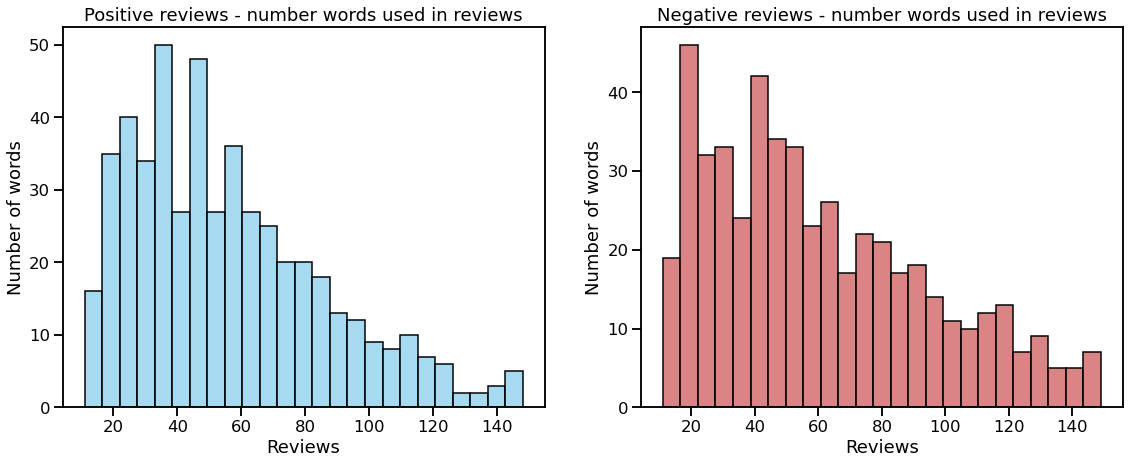

In [19]:
sns.set_context('talk',font_scale=1)
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(19,7))

f1 = sns.histplot(len_vector_p, color = 'skyblue', bins = 25, ax = axs[0])
f1.set_title("Positive reviews - number words used in reviews")
f1.set_xlabel('Reviews')
f1.set_ylabel('Number of words')

f2 = sns.histplot(len_vector_n, color = 'indianred', bins = 25, ax = axs[1])
f2.set_title("Negative reviews - number words used in reviews")
f2.set_xlabel('Reviews')
f2.set_ylabel('Number of words')
plt.show()

The number of words used in reviews is pretty the same for both positive and negative ones, with an average of 55 words for positive reviews and an average of 60 word/review for the negative ones. 

### Most used words in reviews

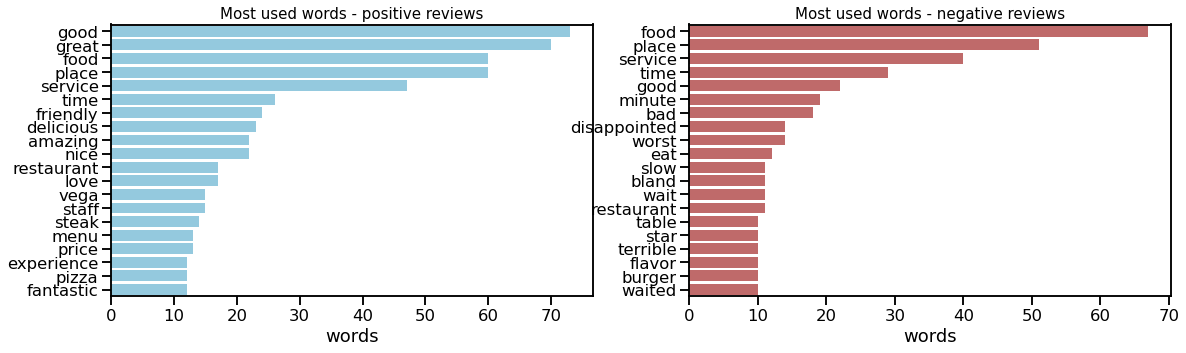

In [20]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(19,5))

g = sns.barplot(x = "words", y = pos_count.index, data = pos_count, color = "skyblue", orient='h', ax = axs[0])
g.set_title("Most used words - positive reviews", size = 15)

f = sns.barplot(x = 'words', y = neg_count.index, data = neg_count, color = 'indianred', orient = 'h', ax = axs[1])
f.set_title("Most used words - negative reviews", size = 15)

plt.show()

## Sentiment analysis of reviews (VADER model)

Because we have labeled data, we already know which is a posite review and which is a negative one, in a general way. But for a better understanding of customer's opinion about the restaurant, I decided to use a pre trained model that measures the polarity and intensity of emotion for a better performance of the topic modeling model, in order to discover which is the real sentiment of customer regarding the restaurant.

VADER ( Valence Aware Dictionary for Sentiment Reasoning) is a model used for text sentiment analysis that is sensitive to both 
polarity (positive/negative) and intensity (strength) of emotion. It is available in the NLTK package and can be applied directly to unlabeled text data.

The model works best when applied to social media text, but it has also proven itself to be a great tool when analyzing the sentiment of movie reviews and opinion articles.
(source:https://towardsdatascience.com/sentimental-analysis-using-vader-a3415fef7664)

In [21]:
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()
sia.polarity_scores("This is a bad bad example")

{'neg': 0.7, 'neu': 0.3, 'pos': 0.0, 'compound': -0.7906}

The compound score is the sum of positive, negative & neutral scores which is then normalized between -1(most extreme negative) and +1 (most extreme positive). The more Compound score closer to +1, the higher the positivity of the text and vice versa. In the same way, the more compound score is closer to -1, the higher the negativity.

In [22]:
compounds_p = []
for rev in corpus_p:
    compounds_p.append(sia.polarity_scores(rev)['compound'])
    
compounds_n = []
for rev in corpus_n:
    compounds_n.append(sia.polarity_scores(rev)['compound'])

In [23]:
data_Preview = {'review':corpus_p, 'compound_score':compounds_p}
Preview_score_df = pd.DataFrame(data_Preview)

data_Nreview = {'review':corpus_n, 'compound_score':compounds_n}
Nreview_score_df = pd.DataFrame(data_Nreview)

#### Examples of positive reviews and their sentiment score

In [24]:
Preview_score_df.head()

,review,compound_score
0,Wow... Loved this place.,0.5994
1,Stopped by during the late May bank holiday of...,0.6908
2,The selection on the menu was great and so wer...,0.6249
3,The fries were great too.,0.6249
4,A great touch.,0.6249


#### Examples of negative reviews and their sentiment score

In [25]:
Nreview_score_df.head()

,review,compound_score
0,Crust is not good.,-0.3412
1,Not tasty and the texture was just nasty.,-0.5574
2,Now I am getting angry and I want my damn pho.,-0.6908
3,Honeslty it didn't taste THAT fresh.),0.0000
4,The potatoes were like rubber and you could te...,0.5719


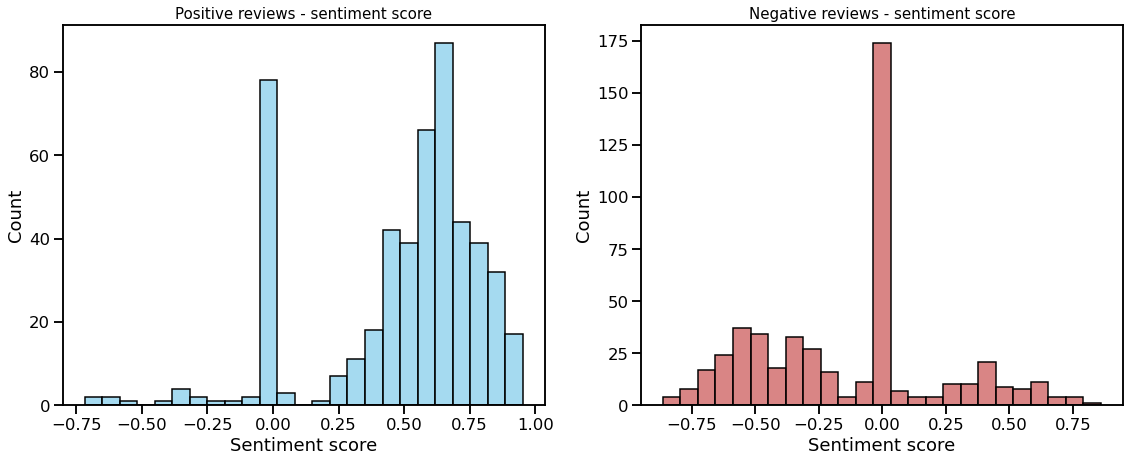

In [26]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(19,7))


f1 = sns.histplot(compounds_p, color = 'skyblue', bins = 25, ax = axs[0])
f2 = sns.histplot(compounds_n, color = 'indianred', bins = 25, ax = axs[1])


f1.set_title("Positive reviews - sentiment score", size = 15)
f1.set_xlabel('Sentiment score')
f2.set_title("Negative reviews - sentiment score", size = 15)
f2.set_xlabel('Sentiment score')
plt.show()

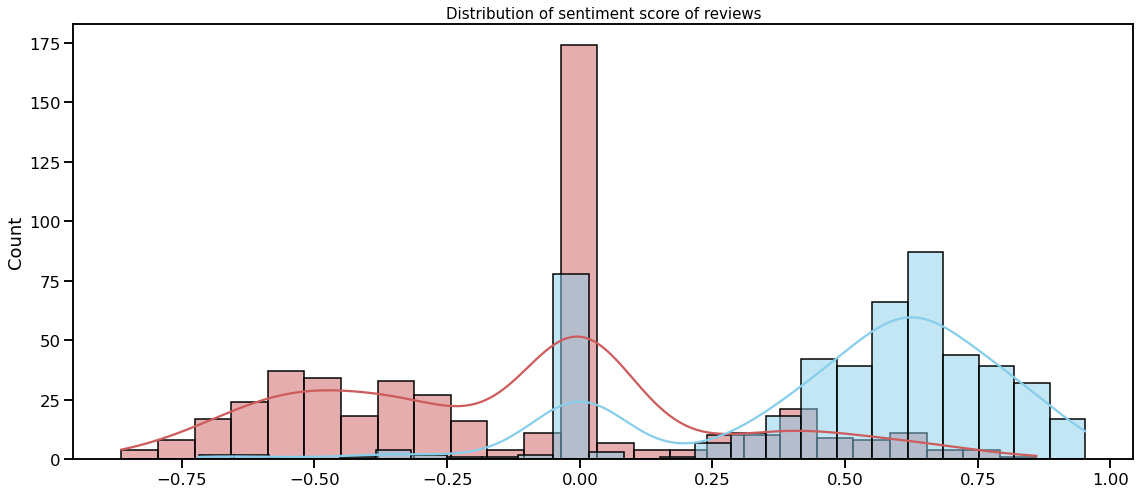

In [27]:
fig = plt.figure(figsize=(19,8))

sns.histplot(compounds_n, color = 'indianred', kde = True, bins = 25)
b=sns.histplot(compounds_p, color = 'skyblue', kde = True, bins = 25)
b.set_title("Distribution of sentiment score of reviews", size = 15)
plt.show()

According to the plots above that shows the distribution of the sentiment score for positive and negative reviews, we can see that are some negative reviews with a positive sentiment score of 0.7 or even 0.7. But this fact is due to usage of words like **"best, love, good"** in ambigous expressions like **"definitely lost the love after this one!"**. The same thing is valid for positive reviews with negative scores.

In [28]:
for rev in Nreview_score_df.sort_values(by = 'compound_score', ascending = False)['review'][:15]:
    print(rev)

We aren't ones to make a scene at restaurants but I just don't get it...definitely lost the love after this one!
Maybe it's just their Vegetarian fare, but I've been twice and I thought it was average at best.
Best of luck to the rude and non-customer service focused new management.
The service here is fair at best.
seems like a good quick place to grab a bite of some familiar pub food, but do yourself a favor and look elsewhere.
There is really nothing for me at postinos, hope your experience is better
The chicken dishes are OK, the beef is like shoe leather.
Also, the fries are without a doubt the worst fries I've ever had.
Paying $7.85 for a hot dog and fries that looks like it came out of a kid's meal at the Wienerschnitzel is not my idea of a good meal.
By this point, my friends and I had basically figured out this place was a joke and didn't mind making it publicly and loudly known.
REAL sushi lovers, let's be honest - Yama is not that good.
The feel of the dining room was more c

In [29]:
print("Sentiment score of the reviews above:")
print(Nreview_score_df.sort_values(by = 'compound_score', ascending = False)['compound_score'][:15].tolist(), end =',')

Sentiment score of the reviews above:
[0.8603, 0.7783, 0.7783, 0.7579, 0.7391, 0.7003, 0.6633, 0.6602, 0.6597, 0.6486, 0.6479, 0.6369, 0.6369, 0.6369, 0.6369],

### Adjusting data

I had an advantage by having labeled data. This helped me in counteracting the model's deficiencies, caused by the ambiguity of human language. The ambiguity of human language is the biggest challenge of "text mining". So, knowing exact how the reviews are labeled (positive or negative), I chose to better adjust the data to the model by droping all of the negative reviews with a positive sentiment score and all of positive reviews with a negative sentiment score.

Also, droping deleting score 0 because considering "neutral and insignifiant" for knowing what customers really desire.

In [30]:
new_compounds_p = Preview_score_df[Preview_score_df['compound_score'] > 0]['compound_score'] 
new_compounds_n = Nreview_score_df[Nreview_score_df['compound_score'] < 0]['compound_score']

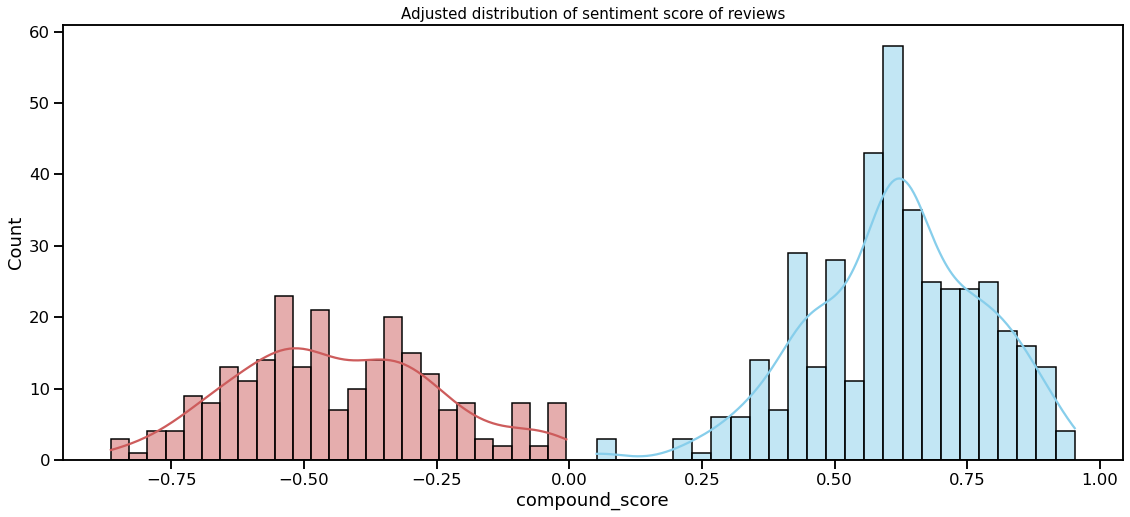

In [31]:
fig = plt.figure(figsize=(19,8))

sns.histplot(new_compounds_n, color = 'indianred', kde = True, bins = 25)
b = sns.histplot(new_compounds_p, color = 'skyblue', kde = True, bins = 25)
b.set_title("Adjusted distribution of sentiment score of reviews", size = 15)
plt.show()

In [32]:
print("Positive reviews:")
pd.DataFrame(new_compounds_p.describe()).transpose()

Positive reviews:


,count,mean,std,min,25%,50%,75%,max
compound_score,406.0,0.616009,0.162163,0.0516,0.4939,0.6249,0.732675,0.9524


In [33]:
print("Negative reviews:")
pd.DataFrame(new_compounds_n.describe()).transpose()

Negative reviews:


,count,mean,std,min,25%,50%,75%,max
compound_score,240.0,-0.434587,0.191466,-0.8637,-0.57075,-0.4588,-0.296,-0.0056


I proceeded in this way by adjusting the data based on the knowledge revealed by the labeled data classes due to the fact that the ultimate goal of this analysis is to identify what customers think and which services can be made better.
**The main purpose of computing the sentiment score and than, performing further data transformation, was to achive a better normalization of the data in order to obtain better results in the final step of this analysis which will be topic modeling.**

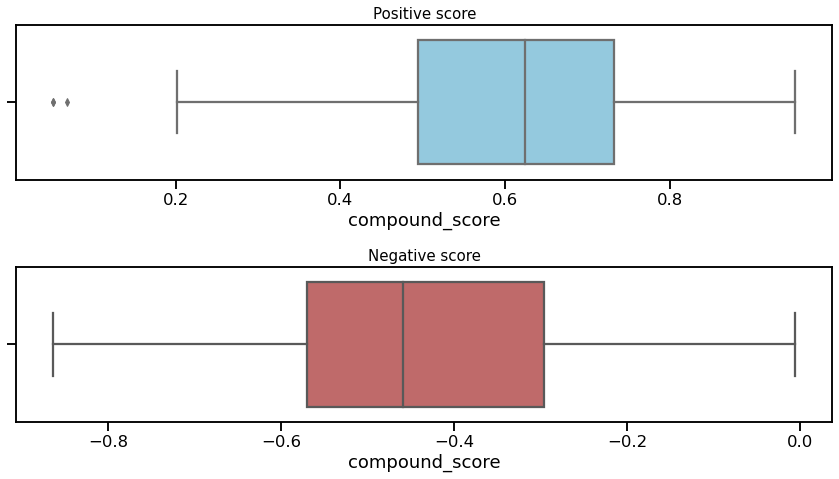

In [34]:
fig, axs = plt.subplots(ncols=1, nrows=2, figsize=(12,7))

b1 = sns.boxplot(new_compounds_p, ax = axs[0], color = 'skyblue')
b2 = sns.boxplot(new_compounds_n, ax = axs[1], color = 'indianred')

b1.set_title("Positive score", size = 15)
b2.set_title("Negative score", size = 15)

plt.tight_layout()

We can now observe that we have normalized data (in terms of the degree of ambiguity of the human language) which will make the results obtained in the last step of this analysis much clearer.

## Topic modeling with Gensim

**Topic modeling** is a type of statistical modeling tool which is used to assess what all abstract topics are being discussed in a set of documents. Topic modeling, by its construction solves the problem of creating topic in an unsupervised manner.

**Gensim** is an open source library in python which is used in unsupervised topic modelling and natural language processing. It is designed to extract semantic topics from documents. It can handle large text collections. Hence it makes it different from other machine learning software packages which target memory processing. Gensim also provides efficient multicore implementations for various algorithms to increase processing speed. It provides more convenient  facilities for text processing than other packages like Scikit-learn, R etc.

In [35]:
id2word_p = corpora.Dictionary(korpus_p)
x_korpus_p = [id2word_p.doc2bow(text) for text in korpus_p]

id2word_n = corpora.Dictionary(korpus_n)
x_korpus_n = [id2word_n.doc2bow(text) for text in korpus_n]

In [36]:
x_korpus_p[:10]

[[(0, 1), (1, 1), (2, 1)],
 [(0, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1)],
 [(10, 1), (11, 1), (12, 1), (13, 1)],
 [(10, 1), (14, 1)],
 [(10, 1), (15, 1)],
 [(16, 1), (17, 1)],
 [(18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1)],
 [(24, 1), (25, 1)],
 [(26, 1), (27, 1)],
 [(17, 1), (28, 1)]]

In [37]:
x_korpus_n[:10]

[[(0, 1), (1, 1)],
 [(2, 1), (3, 1), (4, 1)],
 [(5, 1), (6, 1), (7, 1)],
 [(8, 1), (9, 1), (10, 1)],
 [(11, 1), (12, 1), (13, 1), (14, 1), (15, 1)],
 [],
 [(16, 1), (17, 1), (18, 1), (19, 1), (20, 1)],
 [(21, 1), (22, 1), (23, 1), (24, 1)],
 [(25, 1), (26, 1), (27, 1)],
 [(28, 1), (29, 1), (30, 1)]]

Running the model with different parameters, I noticed that the optimal number of clusters for both positive and negative reviews is 3.

In [38]:
lda_model_p = gensim.models.ldamodel.LdaModel(corpus = x_korpus_p,
                                           id2word = id2word_p,
                                           num_topics = 3, # from num_topics > 3, it strarts to intersect
                                           random_state=100,
                                           update_every=1,
                                           chunksize=58,
                                           passes=10,
                                           alpha = "auto", 
                                           iterations=100)

In [39]:
lda_model_n = gensim.models.ldamodel.LdaModel(corpus = x_korpus_n,
                                           id2word = id2word_n,
                                           num_topics = 3, # from num_topics > 3, it strarts to intersect
                                           random_state=100,
                                           update_every=1,
                                           chunksize=58,
                                           passes=10,
                                           alpha = "auto", 
                                           iterations=100)

## Topics discussed in positive reviews

In [40]:
pyLDAvis.enable_notebook()
vis1 = pyLDAvis.gensim_models.prepare(lda_model_p, x_korpus_p, id2word_p, mds = "mnds", R=20)
vis1

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.195656 -0.027499       1        1  37.899726
0      0.126885 -0.125128       2        1  36.009576
1      0.068771  0.152627       3        1  26.090698, topic_info=          Term       Freq      Total Category  logprob  loglift
10       great  58.000000  58.000000  Default  20.0000  20.0000
17     service  39.000000  39.000000  Default  19.0000  19.0000
27        food  37.000000  37.000000  Default  18.0000  18.0000
1        place  45.000000  45.000000  Default  17.0000  17.0000
119       time  16.000000  16.000000  Default  16.0000  16.0000
..         ...        ...        ...      ...      ...      ...
366  flavorful   3.211144   3.723448   Topic3  -5.1513   1.1956
106      sauce   3.753752   4.506872   Topic3  -4.9952   1.1607
132      lunch   3.482625   4.123542   Topic3  -5.0701   1.1747
1        place   9.629947  45.607852   Topic3  -4.0531  -0.2116
34        good   9.554368  49.647675   Topic3  -4.0609  -0.3044

[92 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
26        1  0.963156     amazing
286       1  0.938797  atmosphere
438       2  0.842143   authentic
588       1  0.975023     awesome
231       1  0.908318         bar
...     ...       ...         ...
85        3  0.809994       tasty
74        2  0.806104       thing
119       3  0.976223        time
206       3  0.964930        vega
62        3  0.951903       visit

[76 rows x 3 columns], R=20, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2])

**The 1st topics cluster** describe the restaurant from a general point of view, emphasizing the quality of the service and the environment in general. 
Customers appreciate the hospitality of the servers, are satisfied with the functionality of the bar and characterize the atmosphere as happy, awesome or amazing. Also, customers describe the staff as friendly and appreciate the composition of the menu.

**The 2nd topics cluster** refers more to the professionalism of the staff, praise the chef and are satisfied with the prices.

**The 3rd topics cluster** reveals the types of food that customers prefer the most: salad, pizza, steak, buffet, breakfast, sandwich, sushi and sauce. The customers characterize this type of food as being delicious and, moreover, they also prefer the beer.

## Topics discussed in negative reviews

In [41]:
pyLDAvis.enable_notebook()
vis2 = pyLDAvis.gensim_models.prepare(lda_model_n, x_korpus_n, id2word_n, mds = "mnds", R=20)
vis2

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.149786  0.076930       1        1  37.500975
1     -0.002608 -0.158023       2        1  34.785957
0     -0.147179  0.081093       3        1  27.713068, topic_info=              Term       Freq      Total Category  logprob  loglift
39            food  49.000000  49.000000  Default  20.0000  20.0000
14            time  20.000000  20.000000  Default  19.0000  19.0000
31           place  41.000000  41.000000  Default  18.0000  18.0000
24          pretty   9.000000   9.000000  Default  17.0000  17.0000
233         server   8.000000   8.000000  Default  16.0000  16.0000
..             ...        ...        ...      ...      ...      ...
466         buffet   3.451581   3.922489   Topic3  -5.0728   1.1554
163  disappointing   3.172014   3.634783   Topic3  -5.1573   1.1471
140           wait   8.080928   9.307414   Topic3  -4.2221   1.1420
8            fresh   3.846908   4.550946   Topic3  -4.9643   1.1152
1             good   6.277537  12.666311   Topic3  -4.4746   0.5813

[93 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
890       3  1.002157  ambiance
652       1  0.858522   average
252       2  0.820795     avoid
752       1  0.972353     awful
82        1  0.424804       bad
...     ...       ...       ...
140       1  0.107441      wait
140       3  0.859530      wait
241       2  0.836534    waited
618       2  0.986122    wanted
51        3  0.861278     worst

[79 rows x 3 columns], R=20, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1])

Regarding the **negative reviews**, we can observe 3 clusters that describe the business from a negative point of view, focusing on **place, service and quality of the food**.

Customers describe the overall **feeling** as disappointing, bad or even awful. From what was observed, unsatisfied customers put the most emphasis on the **waiting time**, mentioning this aspect most of the time. Another important aspect revealed by them is the **quality of the staff**, characterizing them as rude. Some customers complained about the cold and others were not satisfied with the toilets.

Customers are not satisfied with how the following **types of food** are cooked: lunch, burgers, vegetables and chicken. Some do not appreciate sushi either.

They also consider the **prices** to be too high and urges other customers to avoid the restaurant.

## Conclusion

**The following important aspects emerge from the presented analysis:**

**Things to maintain:**
* the bar
* food like: pizza, salad, steak, breakfast, beer

**Things to improve:**
* waiting time
* personnel (in some cases)
* the cold temperature
* bathrooms
* prices
* food like: burgers, vegetables and chicken